In [2]:
# Data Processing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalanced Data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

# Modelling
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import graphviz
from sklearn.inspection import permutation_importance

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
cleaned_churners = pd.read_csv('data/churners_clean_df.csv')

In [4]:
# Replace Unknown values by nan in categorical data
cleaned_churners.replace('Unknown', np.nan, inplace=True)

## Imbalanced data

In [5]:
X = cleaned_churners.drop('Attrition_Flag', axis=1)
y = cleaned_churners['Attrition_Flag']

Class distribution

In [6]:
y.value_counts()

Attrition_Flag
Existing Customer    7524
Attrited Customer    1438
Name: count, dtype: int64

<Axes: ylabel='count'>

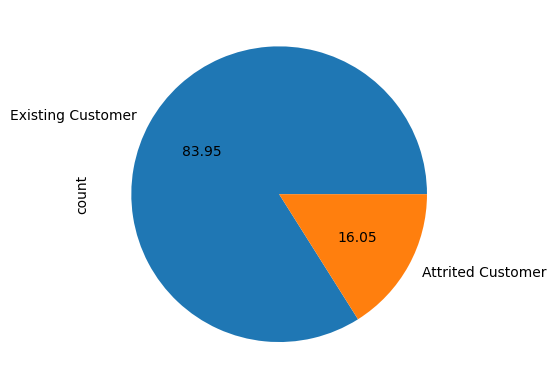

In [7]:
y.value_counts().plot.pie(autopct='%.2f')

- Random Undersampling <br>
- 'not minority' = resample all classes but the minority class

Attrition_Flag
Attrited Customer    1438
Existing Customer    1438
Name: count, dtype: int64

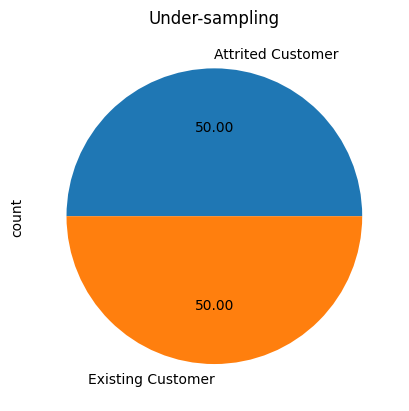

In [8]:
rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_rus, y_rus = rus.fit_resample(X, y)

ax = y_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

# Class distribution after resampling
y_rus.value_counts()

- Random Oversampling <br>
- "not majority" = resample all classes but the majority class

Attrition_Flag
Existing Customer    7524
Attrited Customer    7524
Name: count, dtype: int64

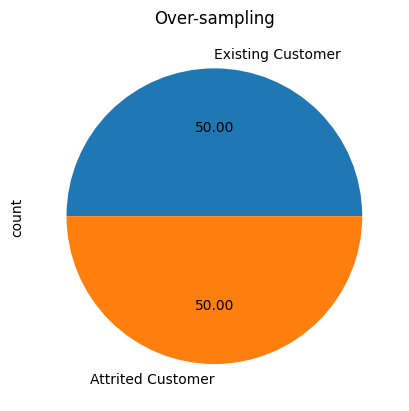

In [9]:
# ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_ros, y_ros = ros.fit_resample(X, y)

ax = y_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

y_ros.value_counts()

- SMOTENC: SMOTE with categorical features

[1 3 4 5 6]


Attrition_Flag
Existing Customer    7524
Attrited Customer    7524
Name: count, dtype: int64

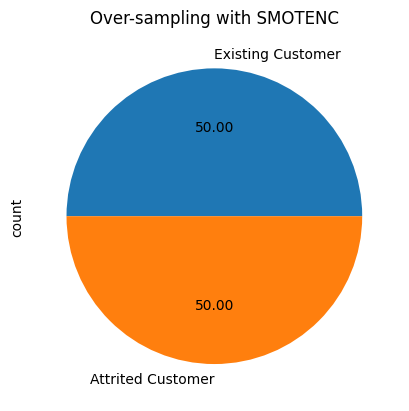

In [10]:
# get index of categorical columns
cat_cols = X.select_dtypes(include = 'object').columns
index = X.columns.get_indexer(cat_cols)
print(index)

smo = SMOTENC(sampling_strategy="minority", categorical_features=[1,3,4,5,6])
X_smo, y_smo = smo.fit_resample(X, y)

ax = y_smo.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling with SMOTENC")

y_smo.value_counts()

## Preprocessing

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, random_state=42, test_size=0.3)

In [12]:
# Define numerical and categorical features
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_features = X_train.select_dtypes(include='object').columns

# Define preprocessing steps for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the preprocessor on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the column names after one-hot encoding
encoded_categorical_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine numerical and categorical column names
all_feature_names = list(numerical_features) + list(encoded_categorical_columns)
print(all_feature_names)

# Create DataFrames with preprocessed features
X_train_preprocessed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Check the preprocessed DataFrames
print("Preprocessed Training Data:")
display(X_train_preprocessed_df.head())

print("\nPreprocessed Testing Data:")
display(X_test_preprocessed_df.head())


['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M', 'Education_Level_College', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Income_Category_$120K +', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver']
Preprocessed Training Data:


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.666572,-0.185813,0.577442,-0.280484,0.707586,0.470740,-0.727070,-1.078097,0.348775,-0.351885,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.256027,-0.185813,0.031525,-0.937004,-1.491265,-1.472551,0.277925,0.860539,-0.143431,0.277486,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.291366,1.460940,-0.241433,1.032556,-1.491265,-0.500905,-0.445715,0.328034,-0.933829,-0.798950,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.119179,-0.185813,0.031525,-1.593524,-1.491265,-0.500905,-0.502846,-1.078097,0.504850,1.218964,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-2.070394,-1.832565,-2.015662,-1.593524,-0.391839,-0.500905,-0.495095,-1.078097,0.347585,0.893328,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



Preprocessed Testing Data:


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Marital_Status_Single,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,-1.796697,0.637564,-1.606225,1.689076,0.707586,0.470740,-0.341596,0.528427,-1.243986,-0.583792,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.256027,0.637564,-0.104954,-0.280484,-0.391839,0.470740,-0.752513,-1.078097,-1.534263,-0.648854,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.940268,-0.185813,1.805754,-0.937004,0.707586,-0.500905,-0.453673,1.457216,-0.073395,3.610184,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.213965,1.460940,0.713921,-0.937004,-0.391839,-0.500905,2.134719,-0.064872,1.512404,-1.038265,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.392875,-1.832565,0.986879,-1.593524,0.707586,-1.472551,-0.637263,0.687166,-0.958842,0.192131,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Choosing Classifiers
### 1. KNN: Classifier implementing the k-nearest neighbors vote.

In [13]:
# Find parameter for KNN model using GridSearchCV
param_knn_grid = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9],
                  'weights':['uniform', 'distance'],
                  'algorithm':['auto', 'brute','kd_tree', 'ball_tree']}

knn = KNeighborsClassifier(n_jobs=-1)
knn_grid = GridSearchCV(knn, param_knn_grid, cv=5, n_jobs=-1)
knn_grid.fit(X_train_processed, y_train)

print(f"{knn_grid.best_estimator_}")
print(f"{knn_grid.best_params_}")
print(f"{knn_grid.best_score_}")

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')
{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}
0.9275601925657296


In [14]:
# KNN Classifier
knn = KNeighborsClassifier(n_jobs=-1, algorithm='auto', n_neighbors=6, weights='distance')
knn.fit(X_train_processed, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance')

### 2. Random Forest Classifier

In [15]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

### 3. Decision Tree

In [16]:
# Train Decision Tree on Classification Task
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(X_train_processed, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [17]:
# Print Text Representation
text_representation = tree.export_text(dt_clf)
print(text_representation)

with open("visuals/decistion_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_10 <= -0.00
|   |--- feature_7 <= -0.37
|   |   |--- feature_11 <= 0.49
|   |   |   |--- feature_3 <= 0.05
|   |   |   |   |--- feature_3 <= -0.61
|   |   |   |   |   |--- feature_1 <= 1.87
|   |   |   |   |   |   |--- feature_29 <= 0.50
|   |   |   |   |   |   |   |--- feature_25 <= 0.50
|   |   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |   |   |--- feature_25 >  0.50
|   |   |   |   |   |   |   |   |--- class: Existing Customer
|   |   |   |   |   |   |--- feature_29 >  0.50
|   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |--- feature_1 >  1.87
|   |   |   |   |   |   |--- feature_10 <= -0.25
|   |   |   |   |   |   |   |--- class: Attrited Customer
|   |   |   |   |   |   |--- feature_10 >  -0.25
|   |   |   |   |   |   |   |--- class: Existing Customer
|   |   |   |   |--- feature_3 >  -0.61
|   |   |   |   |   |--- feature_9 <= -0.56
|   |   |   |   |   |   |--- feature_4 <= -0.94
|   |   |   |   |   |   | 

Plot Tree with plot_tree

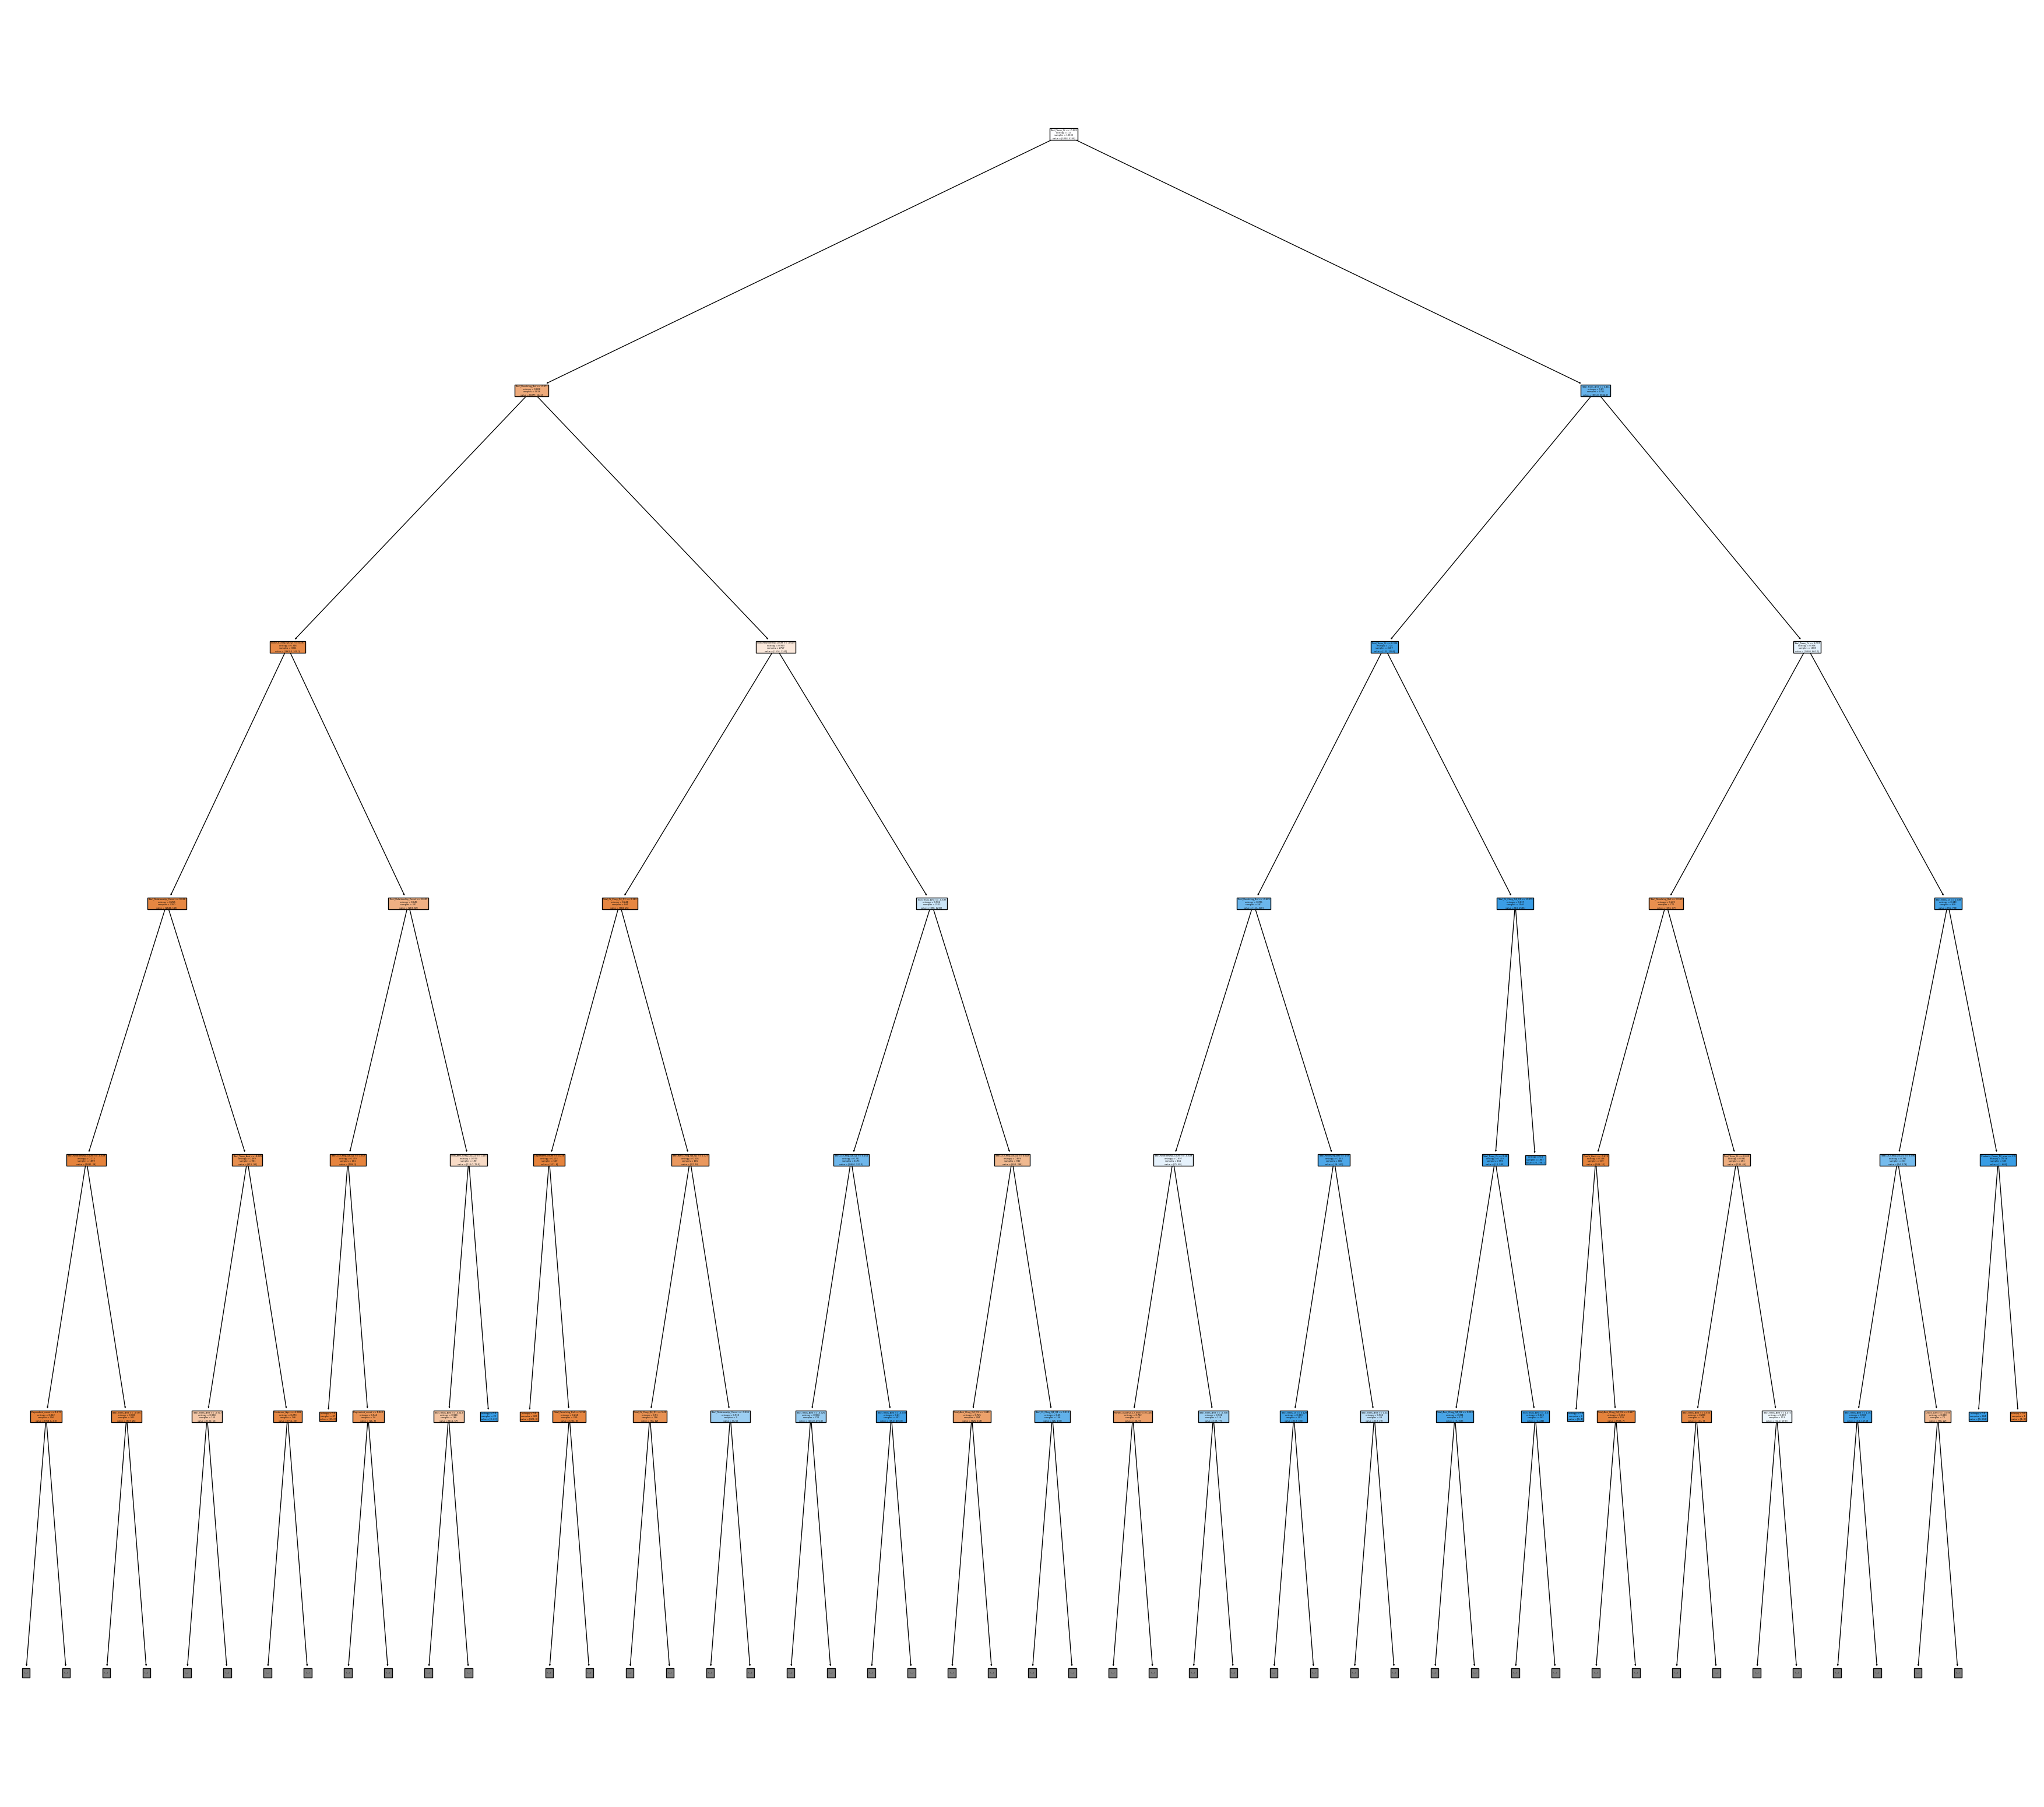

In [18]:
fig = plt.figure(figsize=(45,40))
_ = tree.plot_tree(dt_clf, feature_names=X_train_preprocessed_df.columns, max_depth=5, filled=True)

fig.savefig("visuals/decistion_tree.png")

Visualize Decision Tree with graphviz

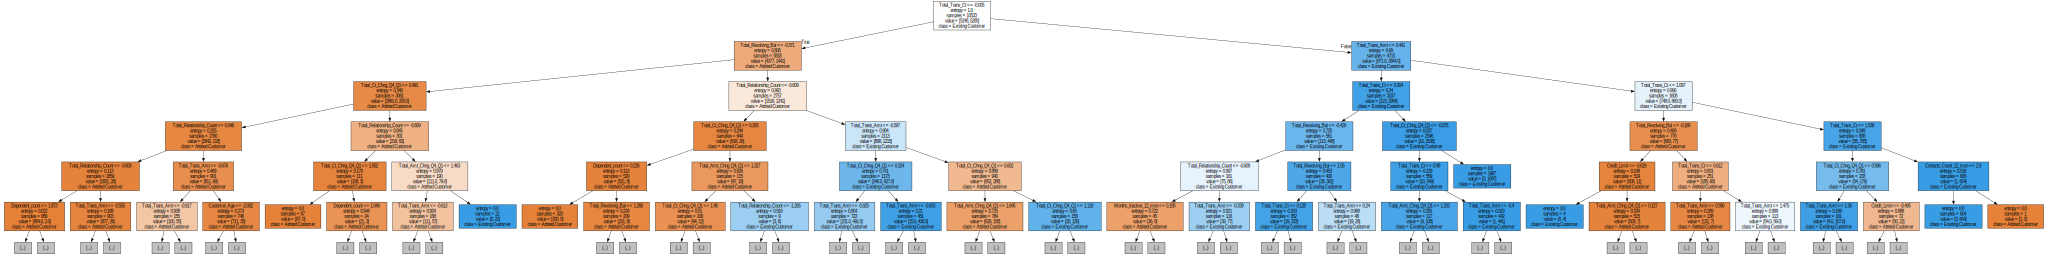

In [19]:
# DOT data
dot_data = tree.export_graphviz(dt_clf, feature_names=X_train_preprocessed_df.columns, 
                                class_names=["Attrited Customer", "Existing Customer"], 
                                max_depth=5,out_file=None, filled=True)

# Drow graph
graph = graphviz.Source(dot_data, format="png")
graph


In [20]:
graph.render("visuals/decision_tree_grphviz")

'visuals\\decision_tree_grphviz.png'

## Evaluation

In [21]:
def evaluate_model(classifier):
    # Make predictions
    y_pred = classifier.predict(X_test_processed)

    # Evaluate the model
    print(f"Evaluation of {classifier}:")
    print(f"Score = {round(classifier.score(X_test_processed, y_test), 4)}")

    # Confusion matrix
    confusion_matrix(y_test, y_pred)
    crosstab = pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)
    display(crosstab)

    # Generate classification report
    report = classification_report(y_test, y_pred, zero_division=1)
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")

evaluate_model(rf_model)
evaluate_model(knn)
evaluate_model(dt_clf)


Evaluation of RandomForestClassifier(random_state=42):
Score = 0.9668


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2217,59,2276
Existing Customer,91,2148,2239
All,2308,2207,4515


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.96      0.97      0.97      2276
Existing Customer       0.97      0.96      0.97      2239

         accuracy                           0.97      4515
        macro avg       0.97      0.97      0.97      4515
     weighted avg       0.97      0.97      0.97      4515

Evaluation of KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance'):
Score = 0.9196


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2225,51,2276
Existing Customer,312,1927,2239
All,2537,1978,4515


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.88      0.98      0.92      2276
Existing Customer       0.97      0.86      0.91      2239

         accuracy                           0.92      4515
        macro avg       0.93      0.92      0.92      4515
     weighted avg       0.93      0.92      0.92      4515

Evaluation of DecisionTreeClassifier(criterion='entropy', random_state=42):
Score = 0.9519


Predicted,Attrited Customer,Existing Customer,All
Actual,,,
Attrited Customer,2174,102,2276
Existing Customer,115,2124,2239
All,2289,2226,4515


Classification Report:
                   precision    recall  f1-score   support

Attrited Customer       0.95      0.96      0.95      2276
Existing Customer       0.95      0.95      0.95      2239

         accuracy                           0.95      4515
        macro avg       0.95      0.95      0.95      4515
     weighted avg       0.95      0.95      0.95      4515



### ROC curve

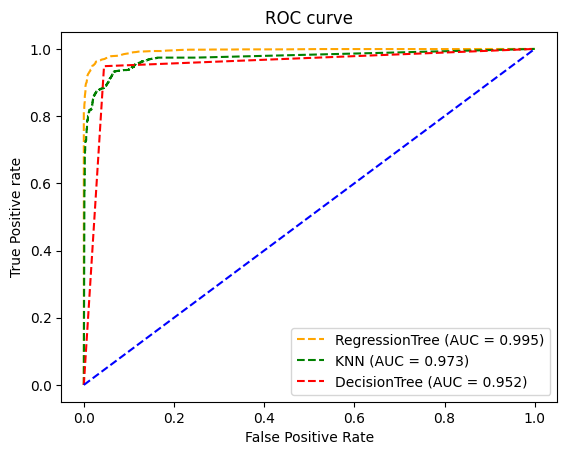

In [22]:
# Predict probabilities
y_prob1 = rf_model.predict_proba(X_test_processed)
y_prob2 = knn.predict_proba(X_test_processed)
y_prob3 = dt_clf.predict_proba(X_test_processed)

# ROC curve for model
fpr1, tpr1, thresh1 = roc_curve(y_test, y_prob1[:,1], 
                        pos_label='Existing Customer')
fpr2, tpr2, thresh2 = roc_curve(y_test, y_prob2[:,1],
                        pos_label='Existing Customer')
fpr3, tpr3, thresh3 = roc_curve(y_test, y_prob3[:,1],
                        pos_label='Existing Customer')

# ROC curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, 
                    pos_label='Existing Customer')

# auc scores
auc_score1 = roc_auc_score(y_test, y_prob1[:,1])
auc_score2 = roc_auc_score(y_test, y_prob2[:,1])
auc_score3 = roc_auc_score(y_test, y_prob3[:,1])

# print(f"RegressionTree: {auc_score1}, KNN: {auc_score2}, DecisionTree: {auc_score3}")

# plot ROC curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='RegressionTree (AUC = %0.3f)' % auc_score1)
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN (AUC = %0.3f)' % auc_score2)
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='DecisionTree (AUC = %0.3f)' % auc_score3)

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# labels
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()



### Investigating Feature Importance

In [23]:
# Feature importance for Random Forest
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({'feature': X_train_preprocessed_df.columns, 'importance': feature_importance})
importance_df_rf = importance_df.sort_values(by='importance', ascending=False)
importance_df_rf

,feature,importance
10,Total_Trans_Ct,0.200277
9,Total_Trans_Amt,0.199221
7,Total_Revolving_Bal,0.116670
11,Total_Ct_Chng_Q4_Q1,0.083609
12,Avg_Utilization_Ratio,0.071740
3,Total_Relationship_Count,0.069993
8,Total_Amt_Chng_Q4_Q1,0.054287
6,Credit_Limit,0.038247
0,Customer_Age,0.030559
2,Months_on_book,0.022224


In [24]:
# Feature importance for Decision Tree
feature_importance = dt_clf.feature_importances_
importance_df = pd.DataFrame({'feature': X_train_preprocessed_df.columns, 'importance': feature_importance})
importance_df_dt = importance_df.sort_values(by='importance', ascending=False)
importance_df_dt

,feature,importance
10,Total_Trans_Ct,0.399270
9,Total_Trans_Amt,0.196207
7,Total_Revolving_Bal,0.111097
3,Total_Relationship_Count,0.071774
11,Total_Ct_Chng_Q4_Q1,0.068109
8,Total_Amt_Chng_Q4_Q1,0.043606
0,Customer_Age,0.031358
6,Credit_Limit,0.016278
12,Avg_Utilization_Ratio,0.014644
2,Months_on_book,0.007303


In [25]:
from sklearn.inspection import permutation_importance

# Feature importance for KNN
permutation_importance_knn = permutation_importance(knn, X_test_processed, y_test)
feature_importance_knn = permutation_importance_knn.importances_mean
importance_df = pd.DataFrame({'feature': X_train_preprocessed_df.columns, 'importance': feature_importance_knn})
importance_df_knn = importance_df.sort_values(by='importance', ascending=False)
importance_df_knn

,feature,importance
10,Total_Trans_Ct,0.135415
11,Total_Ct_Chng_Q4_Q1,0.038893
9,Total_Trans_Amt,0.037829
3,Total_Relationship_Count,0.036368
7,Total_Revolving_Bal,0.034064
8,Total_Amt_Chng_Q4_Q1,0.018250
12,Avg_Utilization_Ratio,0.016257
4,Months_Inactive_12_mon,0.015637
0,Customer_Age,0.014618
6,Credit_Limit,0.011517


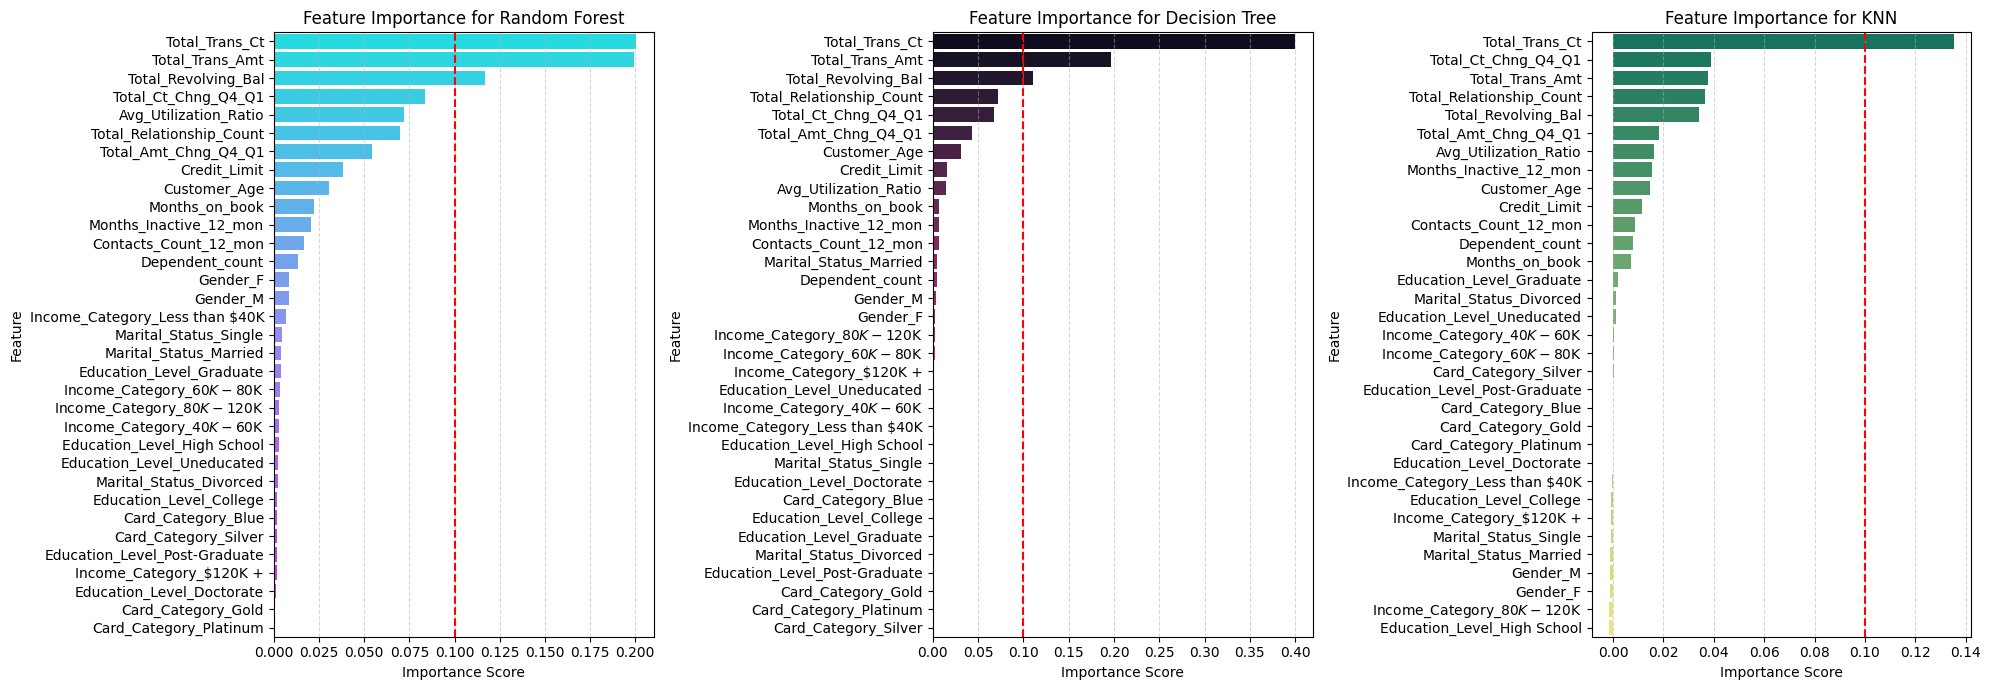

In [26]:
# Plotting feature importance for Random Forest, Decision Tree, and KNN
plt.figure(figsize=(20,7))

# Plotting for Random Forest
plt.subplot(1, 3, 1)
sns.barplot(x='importance', y='feature', data=importance_df_rf, hue='feature', palette='cool')
plt.title("Feature Importance for Random Forest")
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.axvline(0.1, color='r', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Plotting for Decision Tree
plt.subplot(1, 3, 2)
sns.barplot(x='importance', y='feature', data=importance_df_dt, 
            hue='feature', palette='rocket')
plt.title("Feature Importance for Decision Tree")
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.axvline(0.1, color='r', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Plotting for KNN
plt.subplot(1, 3, 3)
sns.barplot(x='importance', y='feature', data=importance_df_knn, hue='feature', palette='summer')
plt.title("Feature Importance for KNN")
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.axvline(0.1, color='r', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig('visuals/feature_importance.png')
plt.show()
